In [1]:
import kagglehub
paultimothymooney_medical_speech_transcription_and_intent_path = kagglehub.dataset_download('paultimothymooney/medical-speech-transcription-and-intent')
paultimothymooney_scispacy_pretrained_models_path = kagglehub.dataset_download('paultimothymooney/scispacy-pretrained-models')

print('Data source import complete.')

100%|██████████| 5.27G/5.27G [03:40<00:00, 25.7MB/s]

Extracting files...


100%|██████████| 987M/987M [00:45<00:00, 22.7MB/s]

Extracting files...


Data source import complete.


**Medical Text Exploration**

In [2]:
!pip install scispacy
!pip install pysoundfile
!apt-get install libav-tools -y
!apt-get install zip
!pip freeze > '../working/dockerimage_snapshot.txt'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.4 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578643 sha256=4d37c0414b80b5a2d37f6cca656cff00d1d27c7ce9fbe911bab2bdeada66c5b7
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'libav

In [3]:
from fastai.text import *
from fastai.vision import *
import spacy
from spacy import displacy
import scispacy
import librosa
import librosa.display
import soundfile as sf
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import IPython
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Get full file path
overview_path = os.path.join(
    paultimothymooney_medical_speech_transcription_and_intent_path,
    'medical speech transcription and intent',
    'Medical Speech, Transcription, and Intent',
    'overview-of-recordings.csv'
)

# Load the CSV file into a DataFrame
overview = pd.read_csv(overview_path)
df = pd.DataFrame(overview)

# Verify the data
overview.head()

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495


# Extarct key  data subsections

In [5]:
overview = overview[['file_name','phrase','prompt','overall_quality_of_the_audio','speaker_id']]
overview=overview.dropna()
overviewAudio = overview[['file_name','prompt']]
overviewAudio['spec_name'] = overviewAudio['file_name'].str.rstrip('.wav')
overviewAudio = overviewAudio[['spec_name','prompt']]
overviewText = overview[['phrase','prompt']]
noNaNcsv = overview_path
noNaNcsv = pd.read_csv(noNaNcsv)
noNaNcsv = noNaNcsv.dropna()
noNaNcsv = noNaNcsv.to_csv('overview-of-recordings.csv',index=False)
noNaNcsv

In [6]:
overview[110:120]

,file_name,phrase,prompt,overall_quality_of_the_audio,speaker_id
110,1249120_43898158_80144458.wav,My body aches on the inside between my hips an...,Internal pain,3.33,43898158
111,1249120_44027675_12530930.wav,I have a foot ache after running 500m with my ...,Foot ache,3.33,44027675
112,1249120_38548574_109106533.wav,"I was diagnosed with B12-deficiency anemia, w...",Feeling cold,3.00,38548574
113,1249120_35350617_79852662.wav,"i feel hurt, lot of pain in my heart",Emotional pain,3.67,35350617
114,1249120_43719934_15555042.wav,I read a book for along time and when I finish...,Head ache,3.67,43719934
115,1249120_31349958_15229477.wav,I break out on my face very frequently,Acne,3.67,31349958
116,1249120_18985376_66234921.wav,I have tried to relief it but I can't,Body feels weak,3.00,18985376
117,1249120_41336418_55313967.wav,I stopped sports because I get Injury from sports,Injury from sports,3.67,41336418
118,1249120_43788827_53247832.wav,Every time I take a deep breath I start coughing,Cough,3.33,43788827
119,1249120_40663048_16096306.wav,when i extend my leg there is pain in knee joint,Joint pain,3.67,40663048




# Categores of symptoms

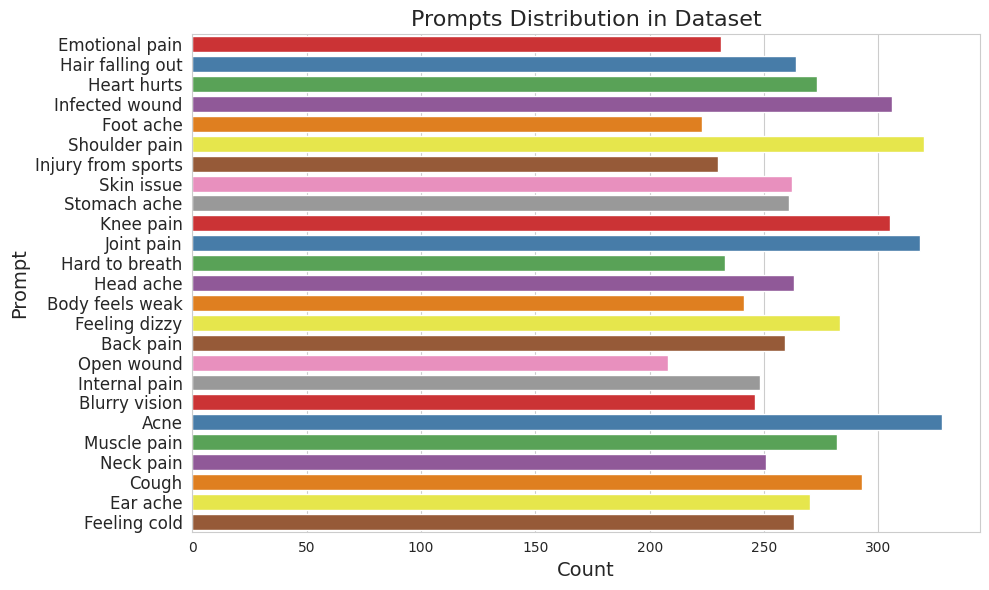

In [7]:

overview = overview.dropna(subset=['prompt'])  # Remove rows with NaN in 'prompt' column

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Increase the figure size

palette = sns.color_palette("Set1", n_colors=len(overview['prompt'].unique()))

promptsPlot = sns.countplot(y='prompt', data=overview, palette=palette)

plt.yticks(rotation=0, fontsize=12)

plt.title('Prompts Distribution in Dataset', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Prompt', fontsize=14)

plt.tight_layout()

plt.show()


# Quality of voice recordingd collected

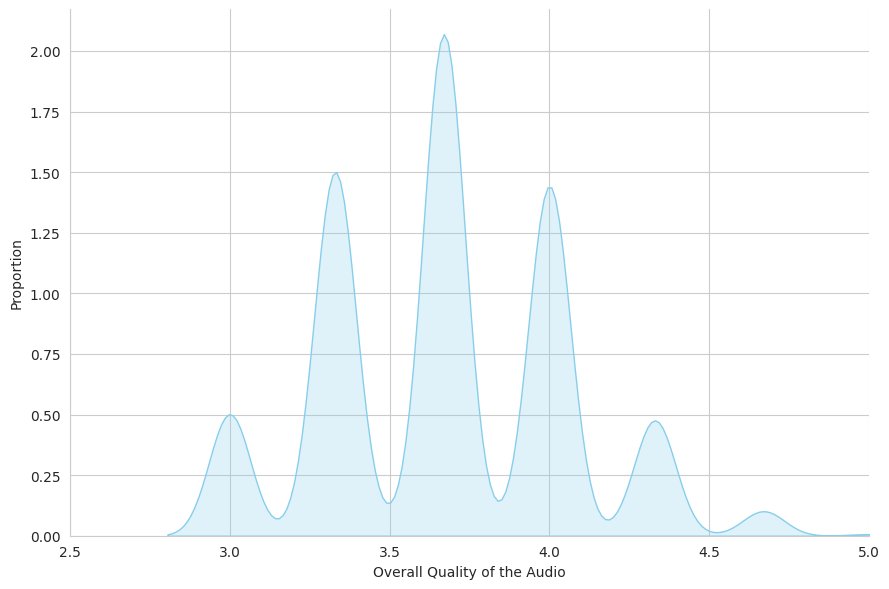

In [8]:
sns.set_style("whitegrid")

# Create the FacetGrid with a larger size (height and aspect ratio)
qualityPlot = sns.FacetGrid(overview, aspect=1.5, height=6)  # Increased size with height=8

# Plot the KDE with sky blue color
qualityPlot.map(sns.kdeplot, 'overall_quality_of_the_audio', shade=True, color='skyblue')

# Set the x-axis limit based on the data
qualityPlot.set(xlim=(2.5, overview['overall_quality_of_the_audio'].max()))

# Set axis labels
qualityPlot.set_axis_labels('Overall Quality of the Audio', 'Proportion')

# Show the plot
qualityPlot.tight_layout()
plt.show()


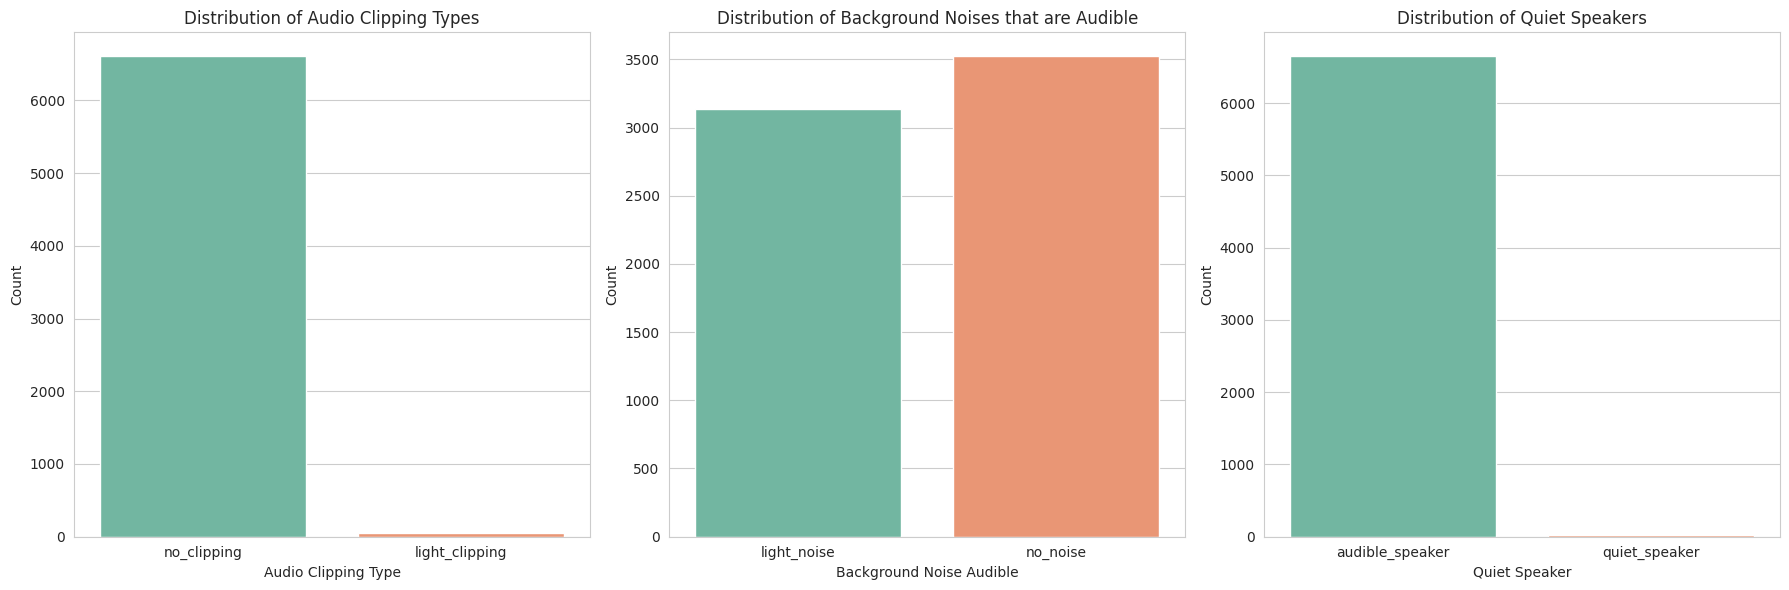

In [9]:
# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of audio clipping types
sns.countplot(data=df, x='audio_clipping', palette='Set2', ax=axes[0])
axes[0].set_title('Distribution of Audio Clipping Types')
axes[0].set_xlabel('Audio Clipping Type')
axes[0].set_ylabel('Count')

# Plot 2: Distribution of background noise
sns.countplot(data=df, x='background_noise_audible', palette='Set2', ax=axes[1])
axes[1].set_title('Distribution of Background Noises that are Audible')
axes[1].set_xlabel('Background Noise Audible')
axes[1].set_ylabel('Count')

# Plot 3: Distribution of quiet speakers
sns.countplot(data=df, x='quiet_speaker', palette='Set2', ax=axes[2])
axes[2].set_title('Distribution of Quiet Speakers')
axes[2].set_xlabel('Quiet Speaker')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

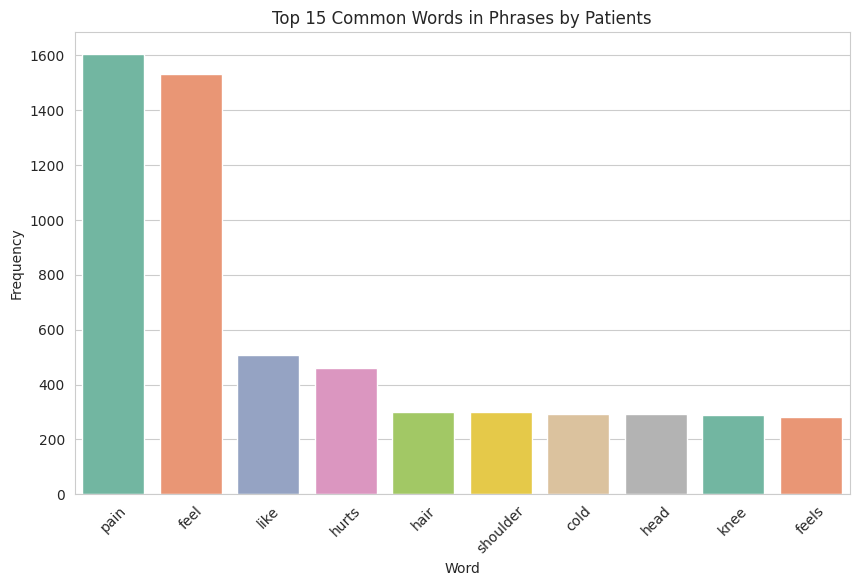

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Initialize CountVectorizer to get word frequencies (top 15)
vectorizer = CountVectorizer(stop_words='english', max_features=15)
X = vectorizer.fit_transform(df['phrase'])

word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq_sum = word_freq.sum(axis=0).sort_values(ascending=False).head(10)

# Plotting the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq_sum.index, y=word_freq_sum.values, palette='Set2')
plt.title('Top 15 Common Words in Phrases by Patients')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

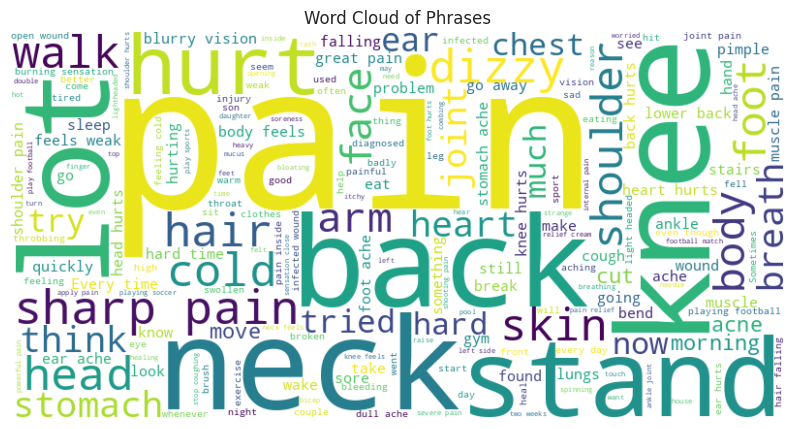

In [11]:
# Create a custom stopwords list
custom_stopwords = set(WordCloud().stopwords)  # Get the default stopwords
custom_stopwords.update(['the', 'in', 'a', 'of', 'have', 'on', 'my','feel'])

# Combine all phrases into a single text blob
text = ' '.join(df['phrase'].astype(str))

# Generate word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, background_color='white', width=800, height=400).generate(text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phrases')
plt.show()